## <center> Unconstrained optimization</center>

### Univariate  Optimization

Optimization of a function that only depends on a single variable is relatively easy. In addition to the analytical approach of seeking the roots of the derivative of the function, we can employ techniques that are similar to the root-finding methods for univariate functions, namely, bracketing methods and Newton’s method. 

In SciPy’s optimize module, the brent function is such a hybrid method, and it is generally the preferred method for optimization of univariate functions with SciPy. This method is a variant of the golden section search method that uses inverse parabolic interpolation to obtain faster convergence. Instead of calling the optimize.golden and optimize.brent functions directly, it is convenient to use the unified interface function optimize.minimize_scalar, which dispatches to the optimize.golden and optimize.brent functions depending on the value of the method keyword argument, where the currently allowed options are 'Golden', 'Brent', or 'Bounded'.

In [1]:
from scipy import optimize as opt
import matplotlib.pyplot as plt
import numpy as np
import sympy

**Example:** minimizing the area of a cylinder with a unit volume
$$ f(r,h) = 2\pi r^2 + 2\pi rh$$
Constrained by: $ g(r,h): \pi r^2h = 1$

Substituting $h = \frac{1}{\pi r^2}$ and writing the function in terms of r:
$$ f(r) = 2\pi r^2 + \frac{2}{r}$$




In [2]:
# Numeric solving

f = lambda r: 2 * np.pi * r ** 2 + 2 / r
r_min = opt.minimize_scalar(f, bracket=(0.1, 4), method="Brent")

print(f"The minimum radius is {r_min.x}, giving an area of {r_min.fun}")

The minimum radius is 0.5419260772557135, giving an area of 5.535810445932086


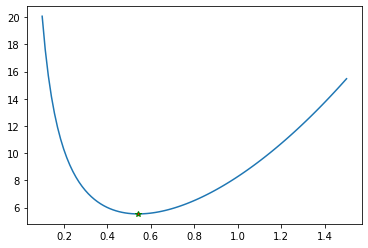

In [3]:
r_vals = np.linspace(0.1, 1.5, 100)

plt.plot(r_vals, f(r_vals))
plt.plot(r_min.x, r_min.fun, marker="*", markeredgecolor="green", markerfacecolor="red");

### Unconstrained Multivariate Optimization

Multivariate optimization is significantly harder than the univariate optimization discussed in the previous section. In particular, the analytical approach of solving the nonlinear equations for roots of the gradient is rarely feasible in the multivariate case, and the bracketing scheme used in the golden search method is also not directly applicable. Instead we must resort to techniques that start at some point in the coordinate space and use different strategies to move toward a better approximation of the minimum point. The most basic approach of this type is to consider the gradient ∇f(x) of the objective function f(x) at a given point x. In general, the negative of the gradient, −∇f(x), always points in the direction in which the function f(x) decreases the most.

#### Newton method

Newton’s method for multivariate optimization is a modification of the steepest descent method that can improve convergence. As in the univariate case, Newton’s method can be viewed as a local quadratic approximation of the function, which when minimized gives an iteration scheme. In the multivariate case, the iteration formula is $x_{k+1} = x_k - H^{-1}_f (x_k) \nabla f (x_k)$, where compared to the steepest descent method, the gradient has been replaced with the gradient multiplied from the left with the inverse of Hessian matrix for the function

In [4]:
x1, x2 = sympy.symbols("x_1, x_2")
f_sym = (x1-1)**4 + 5 * (x2-1)**2- 2*x1*x2


In [5]:
fprime_sym = [f_sym.diff(x_) for x_ in (x1, x2)]
sympy.Matrix(fprime_sym)

Matrix([
[-2*x_2 + 4*(x_1 - 1)**3],
[   -2*x_1 + 10*x_2 - 10]])

In [6]:
fhess_sym = [[f_sym.diff(x1_, x2_) for x1_ in (x1, x2)] for x2_ in (x1, x2)]
sympy.Matrix(fhess_sym)

Matrix([
[12*(x_1 - 1)**2, -2],
[             -2, 10]])

In [7]:
# Vectoryzing the expressions 

f_lmbda = sympy.lambdify((x1, x2), f_sym, 'numpy')
fprime_lmbda = sympy.lambdify((x1, x2), fprime_sym, 'numpy')
fhess_lmbda = sympy.lambdify((x1, x2), fhess_sym, 'numpy')


def func_XY_to_X_Y(f):
    """ Wrapper for f(X) -> f(X[0], X[1])"""
    return lambda X: np.array(f(X[0], X[1]))


f = func_XY_to_X_Y(f_lmbda)
fprime = func_XY_to_X_Y(fprime_lmbda)
fhess = func_XY_to_X_Y(fhess_lmbda)

In [8]:
# Solving the problem
x_opt = opt.fmin_ncg(f, (0, 0), fprime=fprime, fhess=fhess)
x_opt

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
         Hessian evaluations: 8


array([1.88292613, 1.37658523])

#### Quasi-Newton methods

In practice, it may not always be possible to provide functions for evaluating both the gradient and the Hessian of the objective function, and often it is convenient with a solver that only requires function evaluations. For such cases, several methods exist to numerically estimate the gradient or the Hessian or both. Methods that approximate the Hessian are known as quasi-Newton methods, and there are also alternative iterative methods that completely avoid using the Hessian. Two popular methods are the Broyden-Fletcher-Goldfarb-Shanno (BFGS) and the conjugate gradient methods, which are implemented in SciPy as the functions optimize.fmin_bfgs and optimize.fmin_cg. The BFGS method is a quasi-Newton method that can gradually build up numerical estimates of the Hessian, and also the gradient, if necessary. 

In [9]:
x_opt = opt.fmin_bfgs(f, (0, 0))
x_opt

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 9
         Function evaluations: 39
         Gradient evaluations: 13


array([1.88292644, 1.37658595])

In this case the number of function evaluations is even larger, but it is clearly convenient to not have to implement functions for the gradient and the Hessian.In general, the BFGS method is often a good first approach to try, in particular if neither the gradient nor the Hessian is known. If only the gradient is known, then the BFGS method is still the generally recommended method to use, although the conjugate gradient method is often a competitive alternative to the BFGS method. If both the gradient and the Hessian are known, then Newton’s method is the method with the fastest convergence in general. However, it should be noted that although the BFGS and the conjugate gradient methods theoretically have slower convergence than Newton’s method, they can sometimes offer improved stability and can therefore be preferable. 

In [10]:
def func(var):
    x1 = var[0]
    x2 = var[1]
    return (x1 - 1) ** 4 + 5 * (x2 - 1) ** 2 - 2 * x1 * x2


x_opt = opt.minimize(func, [0, 0], method='BFGS')
print(x_opt)

      fun: -3.8672228877100845
 hess_inv: array([[0.11091497, 0.02064493],
       [0.02064493, 0.10048751]])
      jac: array([1.57952309e-06, 6.82473183e-06])
  message: 'Optimization terminated successfully.'
     nfev: 39
      nit: 9
     njev: 13
   status: 0
  success: True
        x: array([1.88292645, 1.37658596])


For problems with many local minima, this can easily lead to a situation when the solver easily gets stuck in a local minimum, even if a global minimum exists. Although there is no complete and general solution to this problem, a practical approach that can partially alleviate this problem is to use a brute force search over a coordinate grid to find a suitable starting point for an terative solver. At least this gives a systematic approach to find a global minimum within given coordinate ranges. In SciPy, the function optimize.brute can carry out such a systematic search. To illustrate this method, consider the problem of minimizing the function:
$$ 4 sin(xπ) + 6sin(yπ)+(x− 1)^2+(y− 1)^2$$
which has a large number of local minima. This can make it tricky to pick a suitable initial point for an iterative solver


In [15]:
def f(X):
    x, y = X
    fun = 4 * np.sin(np.pi * x) + 6 * np.sin(np.pi * y) + (x - 1)**2 + (y - 1)**2
    return fun

x_start = opt.brute(f, (slice(-3, 5, 0.5),  slice(-3, 5, 0.5)), finish=None)
x_start

array([1.5, 1.5])

In [17]:
x_opt = opt.fmin_bfgs(f, x_start)
x_opt

Optimization terminated successfully.
         Current function value: -9.520229
         Iterations: 4
         Function evaluations: 21
         Gradient evaluations: 7


array([1.47586906, 1.48365787])